In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

H5_FILE="./white_h_4096_dm2.h5"
H5_FILE="./white_h_8192_dm1.h5"
H5_FILE="./white_h_8192_dm2.h5"
#!wget http://grqc.ncts.ncku.edu.tw/~lincy/GWDA/white_h_8192_dm2.h5
#!ls /tmp/tf_tmp -al

# Load data
import GWDA.loader
GWdata = GWDA.loader.GWInject(H5_FILE)
RATE   = GWdata.srate
print("Sampling rate : ", RATE)

# ======================== Assemble model
import GWDA.model

tf.reset_default_graph()
DIM = RATE

/usr/lib64/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Sampling rate :  8192


In [2]:
###
###  Construct TF graph
###
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import GWDA.model

tf.reset_default_graph()
DIM    = RATE

keep_prob = tf.placeholder(tf.float32)   ##  for dropout, not used.

x = tf.placeholder(tf.float32, [None,DIM])
y = tf.placeholder(tf.float32, [None,1])

logits = GWDA.model.CNN_3(x, keep_prob, DIM)
#logits = GWDA.model.CNN_4(x, keep_prob, DIM)

# Compute predictions
predict_prob = tf.sigmoid(logits, name="sigmoid_tensor")
predict_op   = tf.cast( tf.round(predict_prob), tf.int32 )


_, accuracy    = tf.metrics.accuracy(labels=y, predictions=predict_op  )
_, sensitivity = tf.metrics.recall(labels=y, predictions=predict_op)
#_, sensitivity = tf.metrics.sensitivity_at_specificity(labels=y, predictions=predict_op, specificity=0.005 )

_, fp = tf.metrics.false_positives(labels=y, predictions=predict_op  )
_, fn = tf.metrics.false_negatives(labels=y, predictions=predict_op  )
_, tp = tf.metrics.true_positives(labels=y, predictions=predict_op  )
_, tn = tf.metrics.true_negatives(labels=y, predictions=predict_op  )

import GWDA.utils
GWDA.utils.report_vars()


Global var size:      4.000 MB | Var # : 10
Train  var size:      4.000 MB | Var # : 10
Local  var size:     64.000 B  | Var # : 8


INFO:tensorflow:Restoring parameters from ./cnn3/model_1.80.ckpt
Test for A= 1.90 : Acc:     1.000, Sen:     1.000, TP/TN/FP/FN:   648   646     0     0 
Test for A= 1.50 : Acc:     1.000, Sen:     1.000, TP/TN/FP/FN:   650   644     0     0 
Test for A= 1.40 : Acc:     1.000, Sen:     1.000, TP/TN/FP/FN:   646   648     0     0 
Test for A= 1.30 : Acc:     0.995, Sen:     0.989, TP/TN/FP/FN:   640   647     0     7 
Test for A= 1.20 : Acc:     0.981, Sen:     0.962, TP/TN/FP/FN:   626   643     0    25 
Test for A= 1.10 : Acc:     0.931, Sen:     0.863, TP/TN/FP/FN:   560   645     0    89 
Test for A= 1.00 : Acc:     0.824, Sen:     0.649, TP/TN/FP/FN:   421   645     0   228 
Test for A= 0.90 : Acc:     0.685, Sen:     0.365, TP/TN/FP/FN:   235   651     0   408 
Test for A= 0.80 : Acc:     0.582, Sen:     0.165, TP/TN/FP/FN:   107   646     0   541 
Test for A= 0.70 : Acc:     0.522, Sen:     0.043, TP/TN/FP/FN:    28   648     0   618 
Test for A= 0.50 : Acc:     0.502, Sen:     0

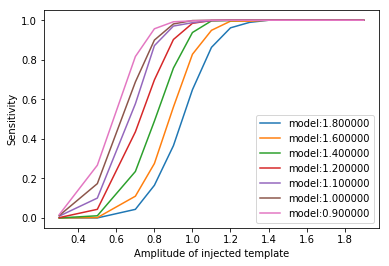

In [3]:
###
###  Testing...
###
BATCH = 4096
ROOT_FOLDER = './cnn3'

TRAIN_A = [1.8, 1.2, 0.8]
TRAIN_A = [1.8, 1.6, 1.4, 1.2, 1.1, 1.0, 0.9]
TEST_LIST = [1.9, 1.5, 1.4, 1.3, 1.2,1.1,1.0,0.9,0.8,0.7,0.5,0.3]

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=50)

    plt.figure()
    for m in TRAIN_A:
        try:
            saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, m ) )
        except: 
            continue

        gacc=[]
        gsen=[]

        for amp in TEST_LIST:
            sess.run(tf.local_variables_initializer())
            
            X, Y  = GWdata.get_test_set(A=amp)
            Xts, _, Yts, _ = train_test_split(X, Y, test_size=0.01, shuffle=True, random_state=None)
            i = int(np.random.random()* int(len(Xts)/BATCH) )
            xbatch = Xts[i*BATCH:(i+1)*BATCH, :]
            ybatch = Yts[i*BATCH:(i+1)*BATCH, :]
            #Xts, Yts   = GWdata.get_shifted_test_set(A=amp, shift=2000)  

            acc, sen, ttp, ttn, tfp, tfn = sess.run([accuracy, sensitivity, tp, tn, fp, fn ], 
                                                          feed_dict={ x: xbatch, y: ybatch })
            gsen.append(sen)
            gacc.append(acc)
            print("Test for A= %4.2f : Acc: %9.3f, Sen: %9.3f, TP/TN/FP/FN: %5d %5d %5d %5d " 
                  % (amp, acc, sen, ttp, ttn, tfp, tfn) )

        plt.plot(TEST_LIST, gsen, label="model:%f"%m)
    
    plt.xlabel("Amplitude of injected template")
    plt.ylabel("Sensitivity")
    plt.legend()
    plt.savefig("test_snr.png")


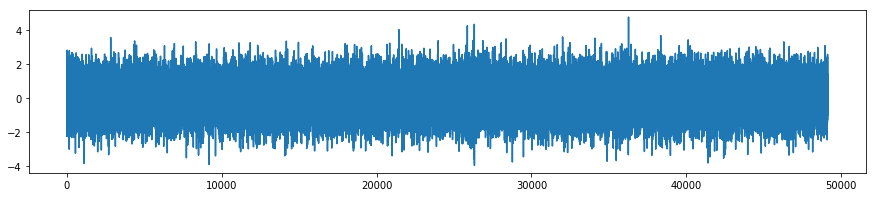

INFO:tensorflow:Restoring parameters from ./cnn3/model_1.60.ckpt


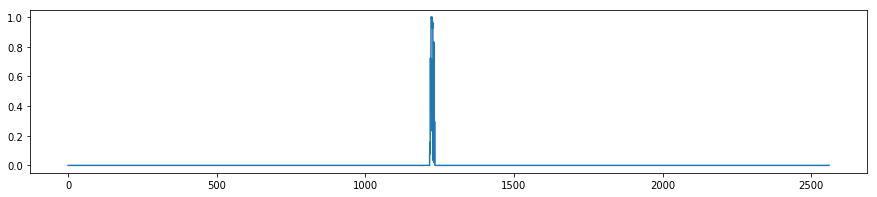

In [17]:
###
###  Testing real data...
###
wopt = {"figsize": (15,3) }

ROOT_FOLDER = './cnn3'
TRAIN_A = [1.6]

SKIP = 5*RATE  ##4*RATE   ## to remove the FFT gibbs effect
data = np.load("real8k/GW150914_H1_w.npy")[SKIP:-SKIP]
plt.figure(**wopt)
plt.plot(data)
plt.show()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=50)

    saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, TRAIN_A[-1] ) )
    sess.run(tf.local_variables_initializer())

    ## predict batch-by-batch    
    DS  = 16    ## Tune this variable for the prediction step
    dsn = 1 + int( (len(data)-RATE) / DS )    ## of prediction point
    MB  = 256
    prob = np.zeros(dsn)
    for i in range(0, dsn, MB):   ###range(int(np.ceil(dsn/MB))):    # for each MB "mini-batch"

        batch  = min(i+MB, dsn) - i                 ### take care the tail
        xbatch = np.zeros([batch, RATE])
        for b in range(batch):
            s = int((b+i)*DS)
            xbatch[b,:] = data[s:s+RATE]
        [p_] = sess.run([predict_prob], feed_dict={ x: xbatch })
        prob[i: i + batch] = p_.flatten()
    
        
plt.figure(**wopt)
plt.plot(prob.flatten())


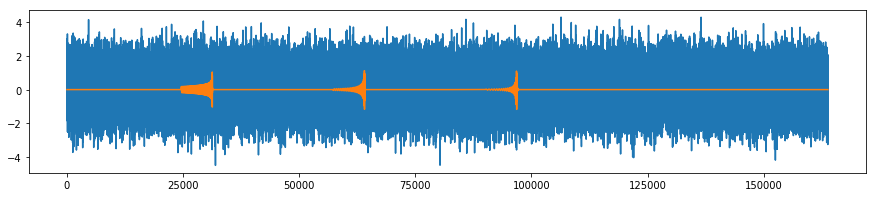

INFO:tensorflow:Restoring parameters from ./cnn3/model_0.90.ckpt


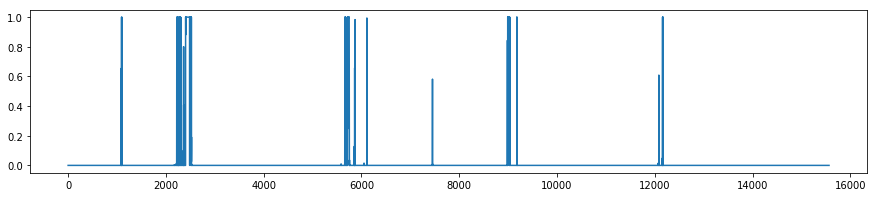

In [15]:
###
###  Testing fake data...
###

#ROOT_FOLDER = './cnn3'
#TRAIN_A = [0.8]

def gen():
    tmp = GWDA.loader.GWInject(H5_FILE)
    inj1 = tmp.f['train_hp'][110]
    inj2 = tmp.f['train_hc'][70]
    inj3 = tmp.f['train_hc'][90]
    A=[0.9,1,1]

    data  = np.random.normal(0,1,RATE*20)
    data[3*RATE:4*RATE] += A[0]*inj1
    data[7*RATE:8*RATE] += A[0]*inj2
    data[11*RATE:12*RATE] += A[0]*inj3
    exact = np.zeros(RATE*20)
    exact[3*RATE:4*RATE] += A[0]*inj1
    exact[7*RATE:8*RATE] += A[1]*inj2
    exact[11*RATE:12*RATE] += A[2]*inj3
    return exact, data

exact, data = gen()
plt.figure(**wopt)
plt.plot(data)
plt.plot(exact)
plt.show()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=50)

    load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, TRAIN_A[-1] ) )
    sess.run(tf.local_variables_initializer())

    ## predict batch-by-batch    
    DS  = 10    ## every ~200 ms
    dsn = 1 + int( (len(data)-RATE) / DS )    ## of prediction point
    MB  = 256
    prob = np.zeros(dsn)
    for i in range(0, dsn, MB):   ###range(int(np.ceil(dsn/MB))):    # for each MB "mini-batch"

        batch  = min(i+MB, dsn) - i                 ### take care the tail
        xbatch = np.zeros([batch, RATE])
        for b in range(batch):
            s = int((b+i)*DS)
            xbatch[b,:] = data[s:s+RATE]
        [p_] = sess.run([predict_prob], feed_dict={ x: xbatch })
        prob[i: i + batch] = p_.flatten()
    
        
plt.figure(**wopt)
plt.plot(prob.flatten())

